<a href="https://colab.research.google.com/github/PriyanshuR23/Industrial_IOT_Predictive_Maintenance/blob/main/Industrial_fan_Visualizations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np

In [2]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

df = pd.read_csv('/content/drive/MyDrive/Datasets/Industrial_fan.csv')

print(df.head())

Mounted at /content/drive
   UDI Product ID Type  Air temperature [K]  Process temperature [K]  \
0    1     M14860    M                298.1                    308.6   
1    2     L47181    L                298.2                    308.7   
2    3     L47182    L                298.1                    308.5   
3    4     L47183    L                298.2                    308.6   
4    5     L47184    L                298.2                    308.7   

   Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  Target  
0                    1551         42.8                0       0  
1                    1408         46.3                3       0  
2                    1498         49.4                5       0  
3                    1433         39.5                7       0  
4                    1408         40.0                9       0  


In [3]:
#Getting Data summary and Insightzz.
def describe_data(df):
  """
  Provides a comprehensive overview of the dataset, including:
    - Shape (rows, columns)
    - Data types of each column
    - Descriptive statistics (count, mean, std, min, max, etc.)
    - Missing value counts
    - Unique values for categorical features
  """
  print("Shape:", df.shape)
  print("\nData Types:\n", df.dtypes)
  print("\nDescriptive Statistics:\n", df.describe(include='all'))
  print("\nMissing Values:\n", df.isnull().sum())

  for col in df.columns:
    if df[col].dtype == 'object':
      print(f"\nUnique values for {col}:\n{df[col].unique()}")


describe_data(df)

Shape: (10000, 9)

Data Types:
 UDI                          int64
Product ID                  object
Type                        object
Air temperature [K]        float64
Process temperature [K]    float64
Rotational speed [rpm]       int64
Torque [Nm]                float64
Tool wear [min]              int64
Target                       int64
dtype: object

Descriptive Statistics:
                 UDI Product ID   Type  Air temperature [K]  \
count   10000.00000      10000  10000         10000.000000   
unique          NaN      10000      3                  NaN   
top             NaN     L57163      L                  NaN   
freq            NaN          1   6000                  NaN   
mean     5000.50000        NaN    NaN           300.004930   
std      2886.89568        NaN    NaN             2.000259   
min         1.00000        NaN    NaN           295.300000   
25%      2500.75000        NaN    NaN           298.300000   
50%      5000.50000        NaN    NaN           300.100

In [4]:
#Fixing null values incase there are any.
print(df.isnull().sum())

UDI                        0
Product ID                 0
Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Target                     0
dtype: int64


In [5]:
# Dropping irrelevant columns
df = df.drop(columns=["UDI", "Product ID"])

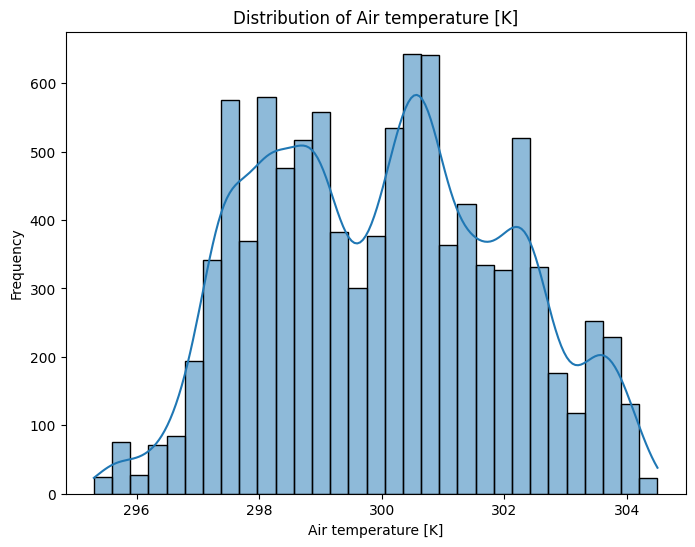

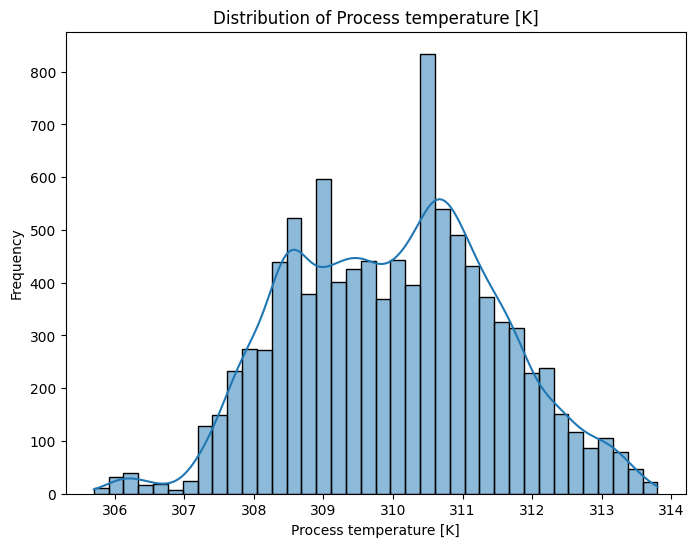

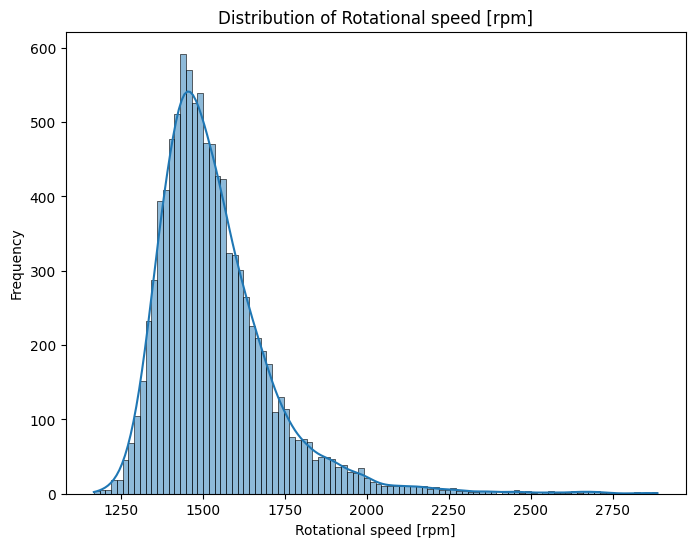

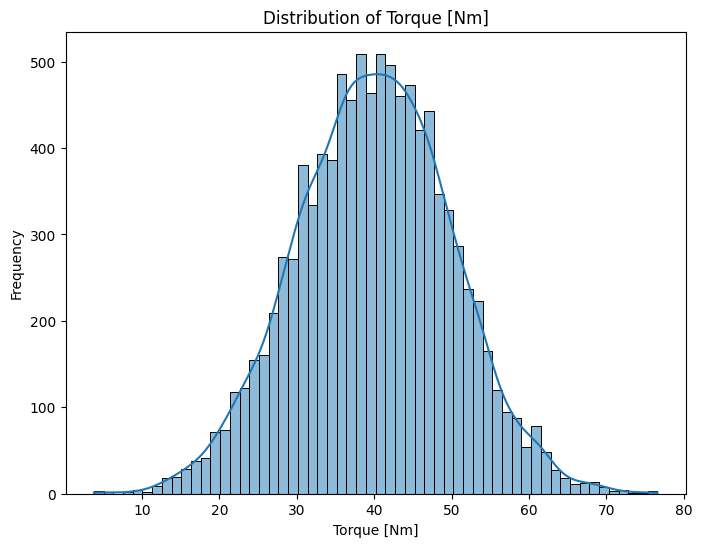

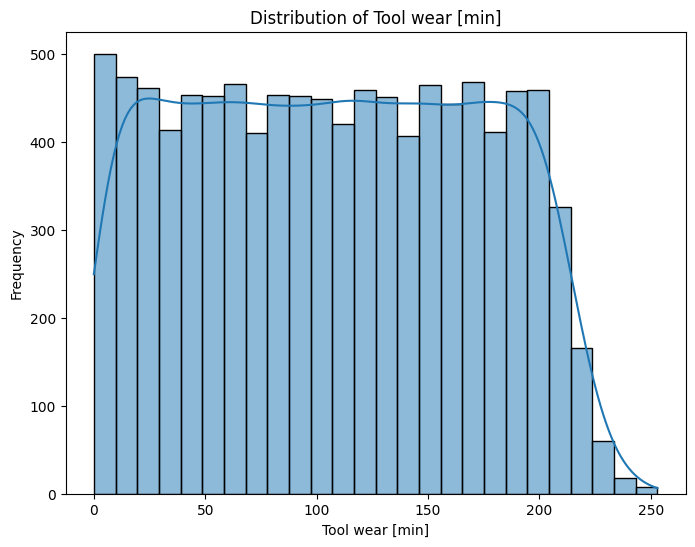

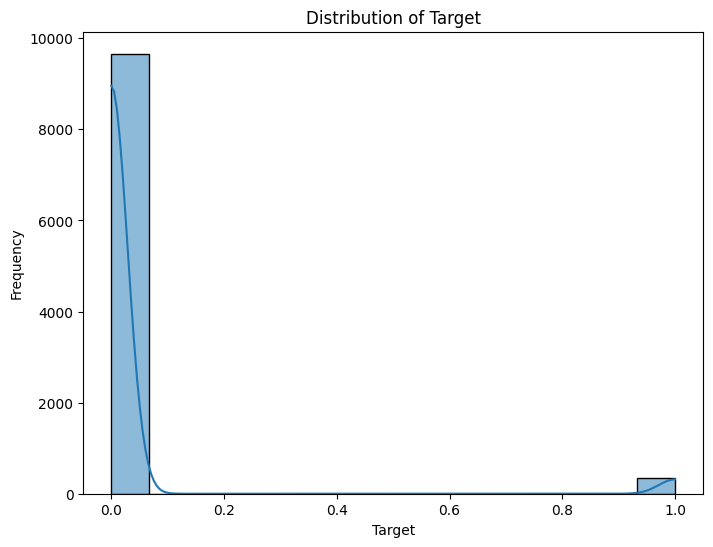

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

#Distribution Plots for the sensors
#We identify the most recurring reading of each sensor.
for column in df.columns:
  if pd.api.types.is_numeric_dtype(df[column]):
    plt.figure(figsize=(8, 6))
    sns.histplot(df[column], kde=True)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()


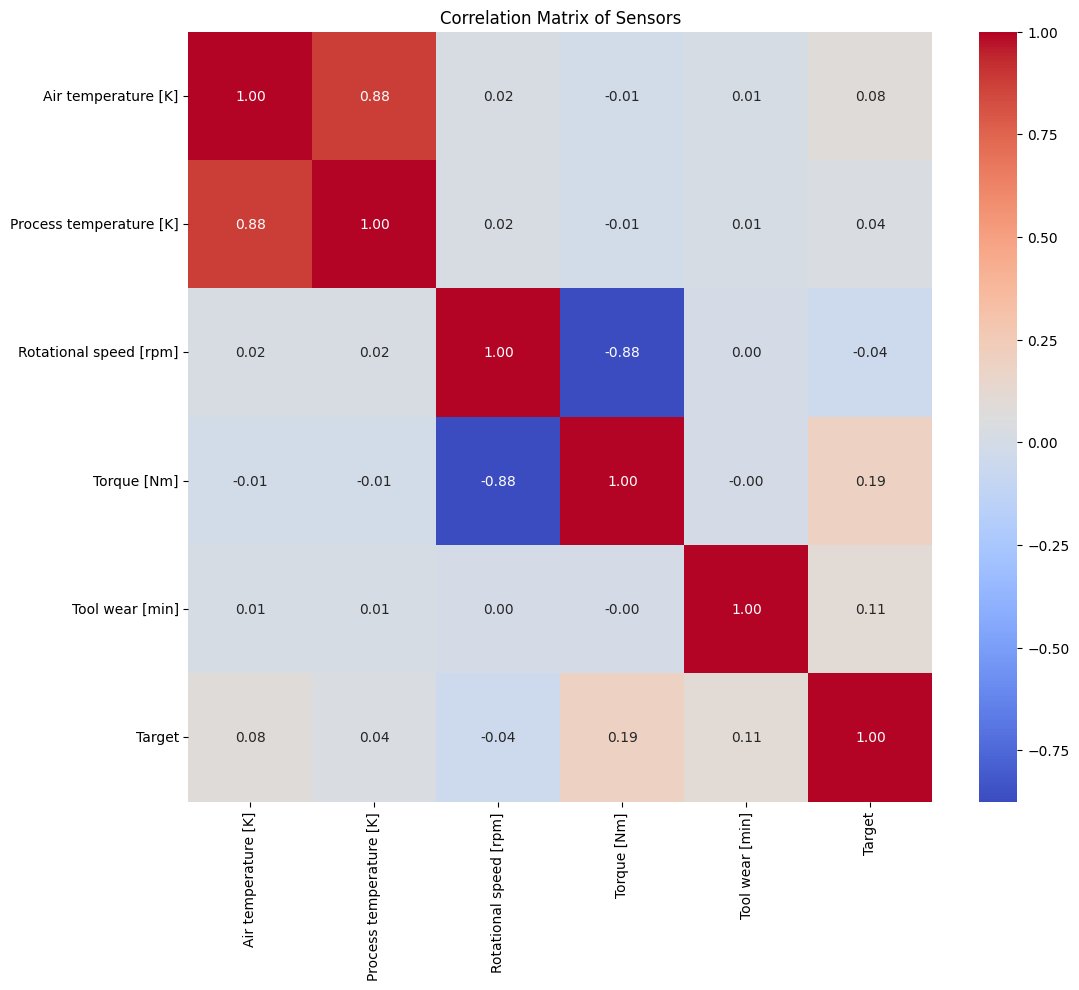

In [7]:
df = df.drop(columns=['Type']) #not required

# Calculate the correlation matrix
correlation_matrix = df.corr()

# Plot the correlation matrix using seaborn
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Sensors')
plt.show()

heatmap of the correlation matrix to showcase the strength of correlation between the sensors, to check for redundancies and correlation b/w vars.

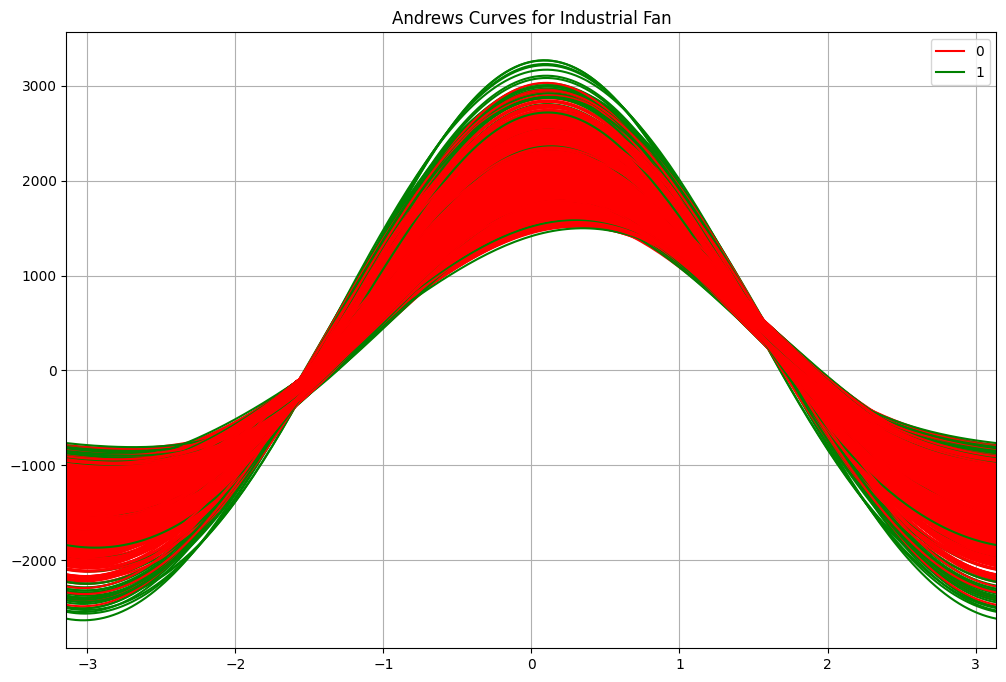

In [8]:
from pandas.plotting import andrews_curves

#Plotting a Andrews curve to reveal grouping

plt.figure(figsize=(12, 8))
andrews_curves(df, 'Target', color=['red', 'green'])
plt.title('Andrews Curves for Industrial Fan')
plt.show()


Smoothness of the curve and overlapping suggests that there are no Extreme outliners and the sensor reading are highly correlated. Non-Linear Relationship.

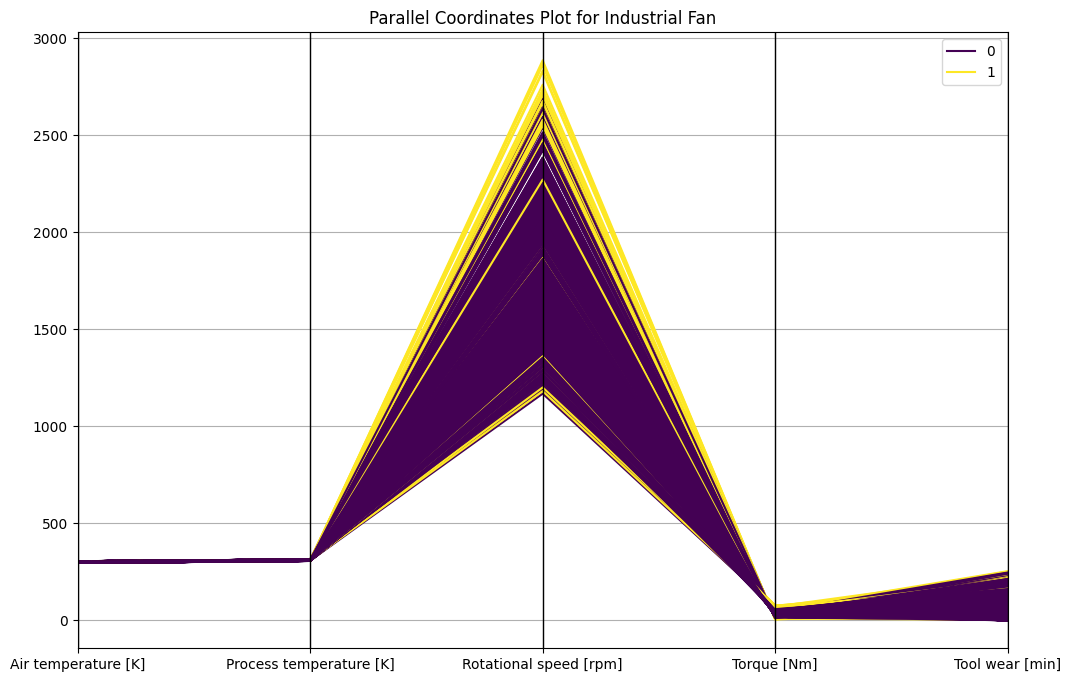

In [9]:
from pandas.plotting import parallel_coordinates

plt.figure(figsize=(12, 8))
parallel_coordinates(df, 'Target', colormap='viridis')
plt.title('Parallel Coordinates Plot for Industrial Fan')
plt.show()


RPM sensors shows clear sep. Clear sep == high prediction power.

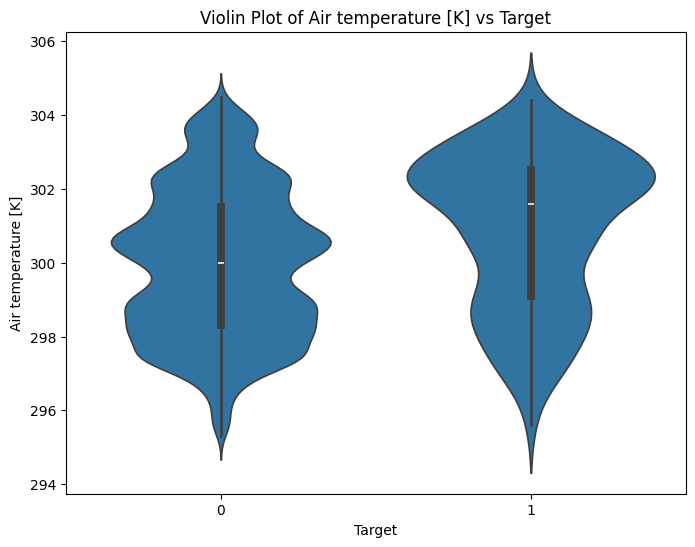

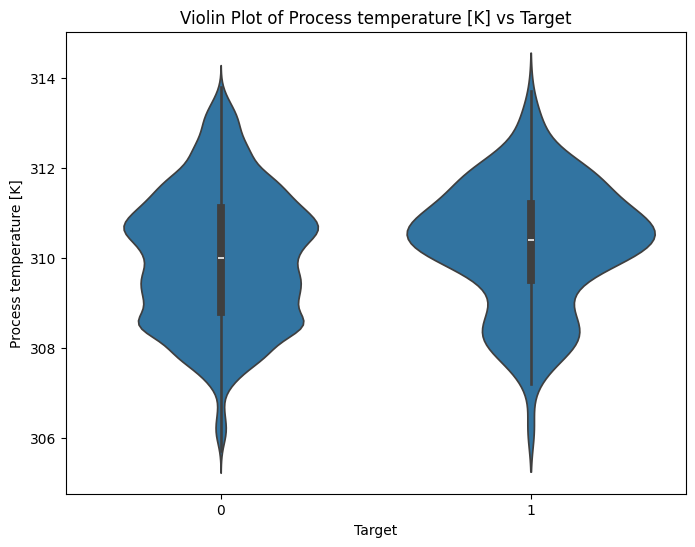

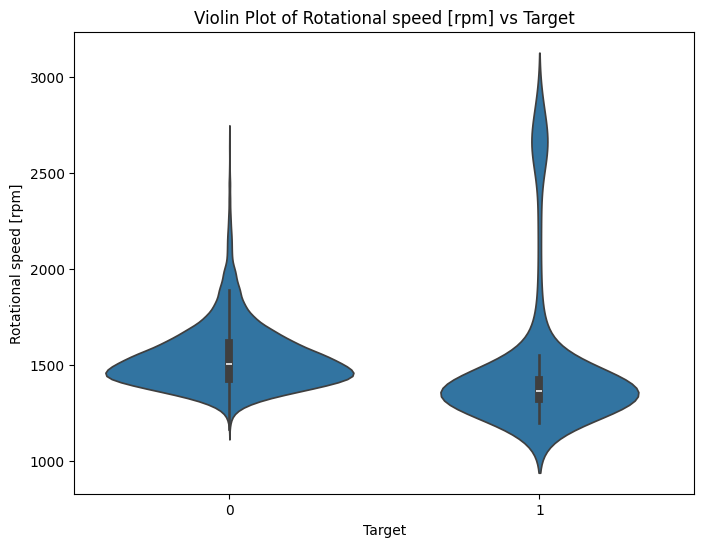

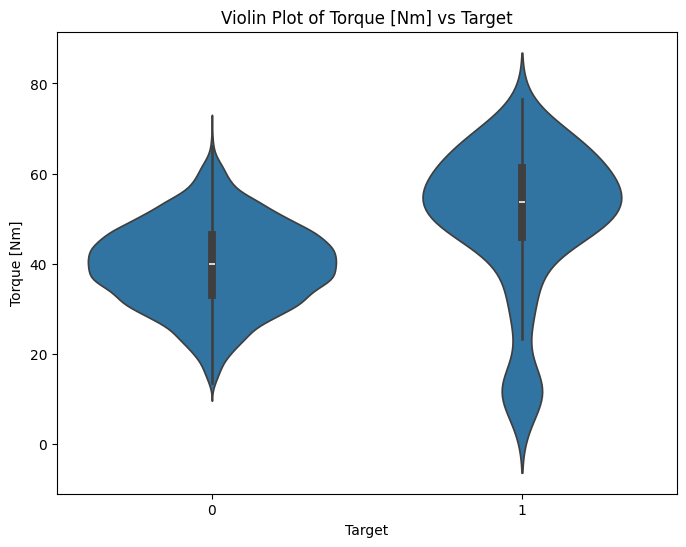

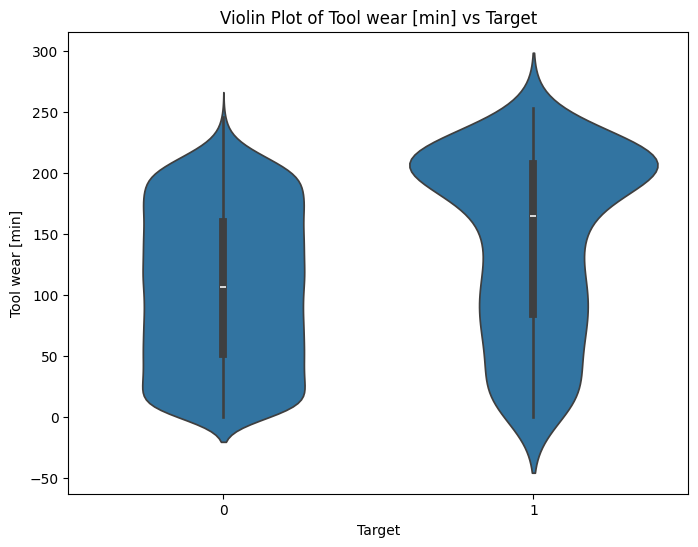

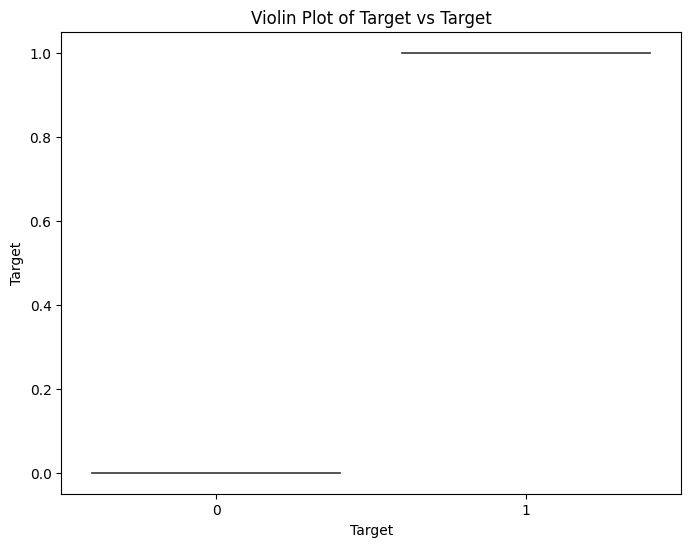

In [10]:
# Voilin Plot wrt Target
for column in df.select_dtypes(include=np.number).columns:
  plt.figure(figsize=(8, 6))
  sns.violinplot(x='Target', y=column, data=df)
  plt.title(f'Violin Plot of {column} vs Target')
  plt.show()


Most plots show us bimodal shapes(outliners). few showcase normal bell shape dis. The white line inside also shows the median at which the sensors generally hit the target variable.

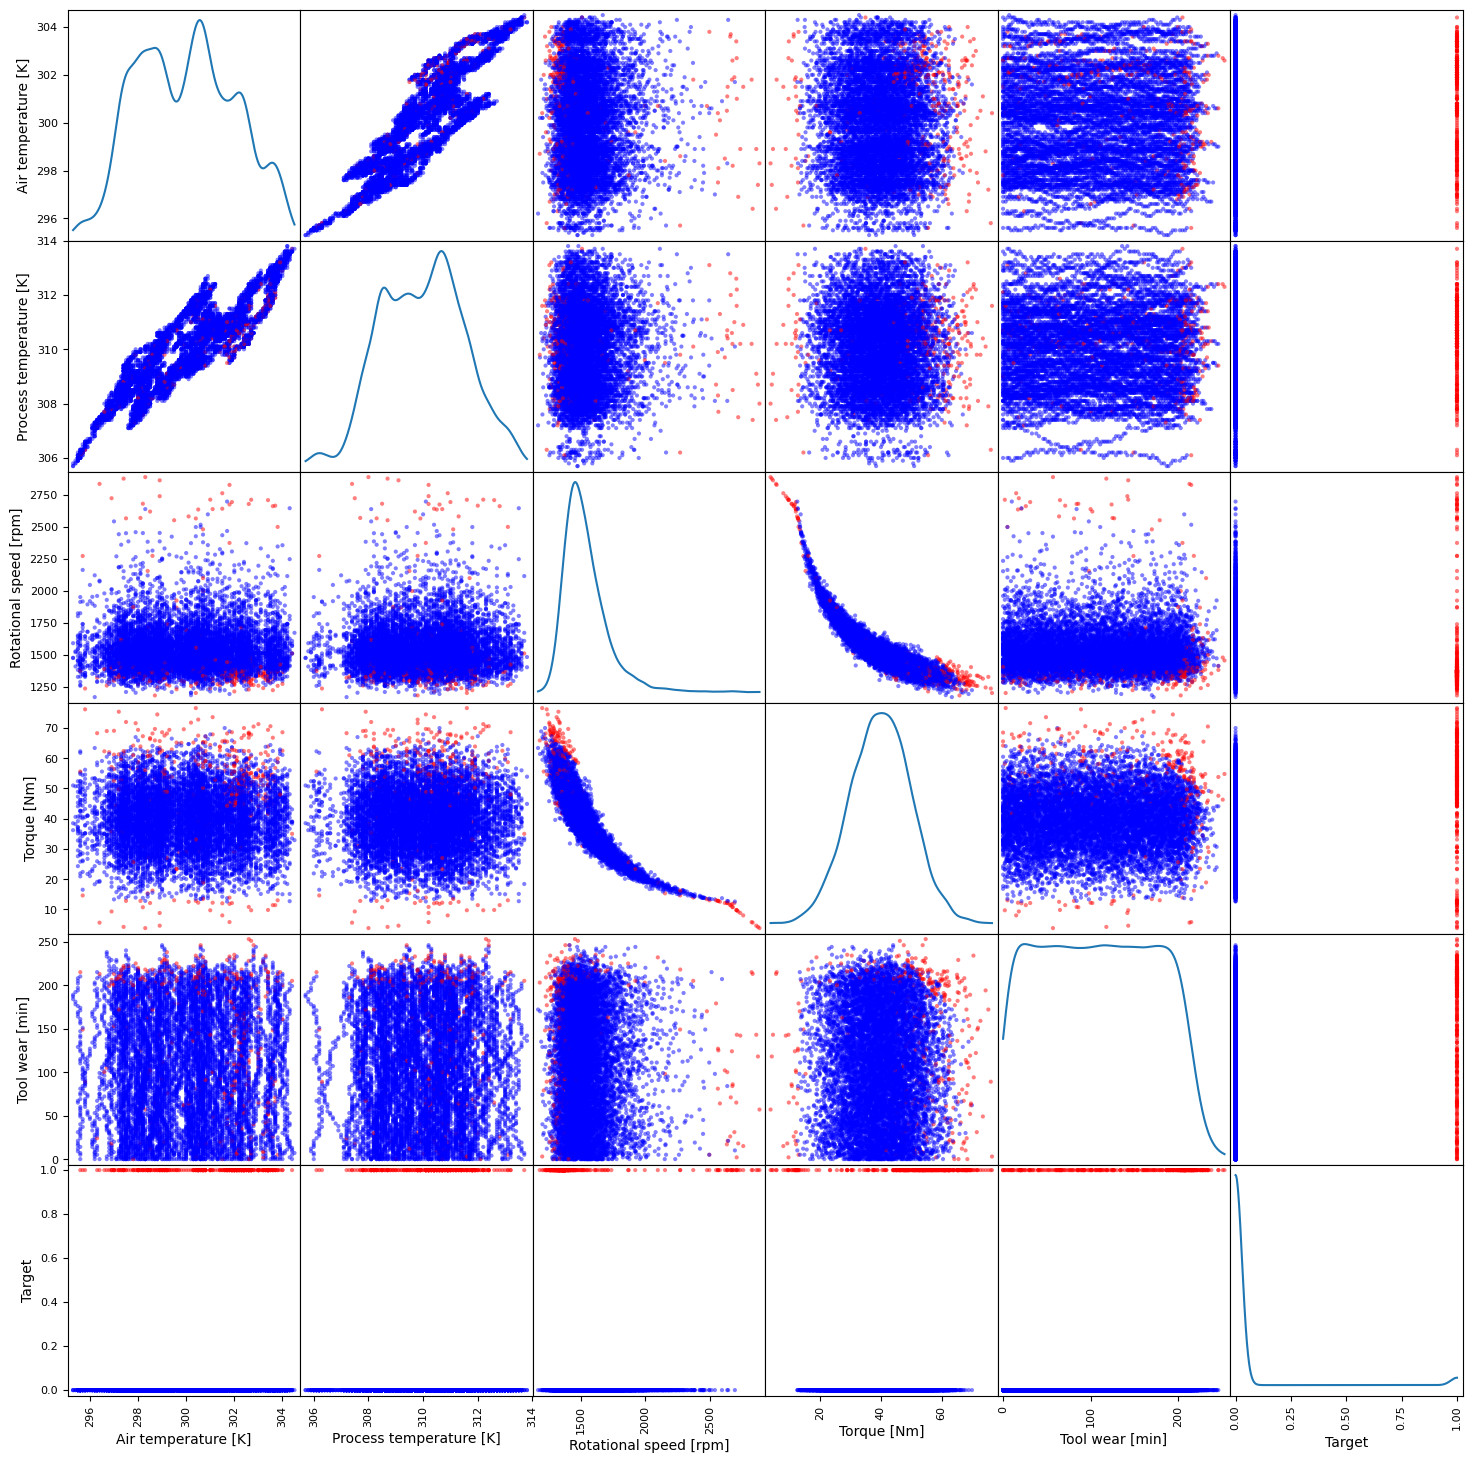

In [11]:
from pandas.plotting import scatter_matrix
numerical_df = df.select_dtypes(include=np.number)

colors = np.where(numerical_df['Target'] == 1, 'red', 'blue')  # Red for 1, blue for 0

scatter_matrix(numerical_df, figsize=(18, 18), diagonal='kde', alpha=0.5, c=colors)
plt.show()

Air and Process temp. show very high correlation (making one redudant), Torque and RPM showcase Hyperbolic Relationship i.e Torque & RPM are inverse.

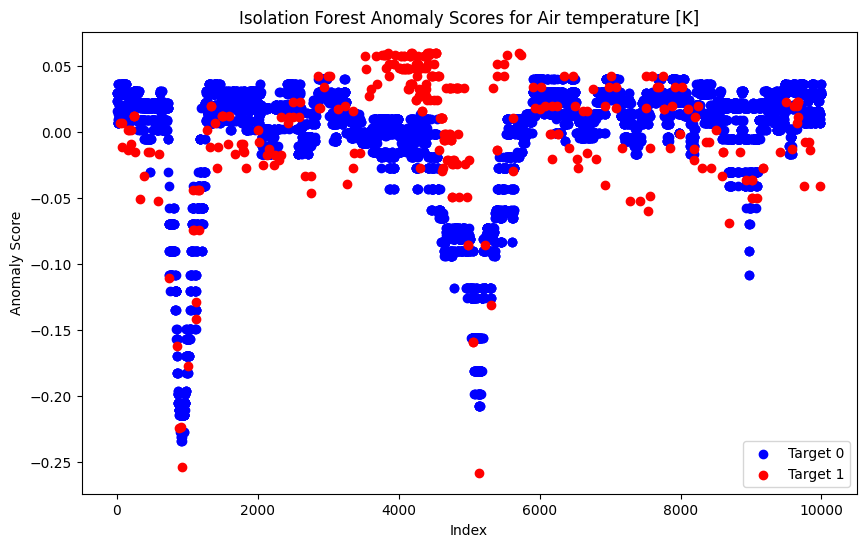

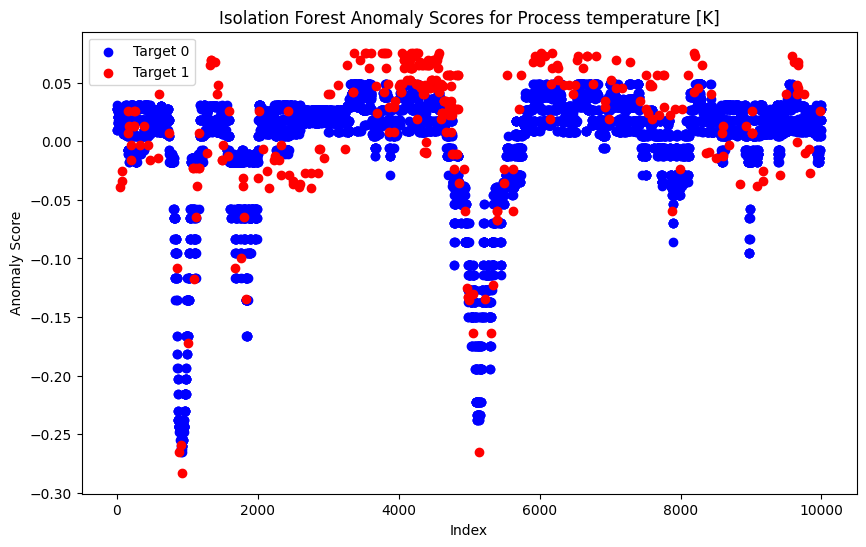

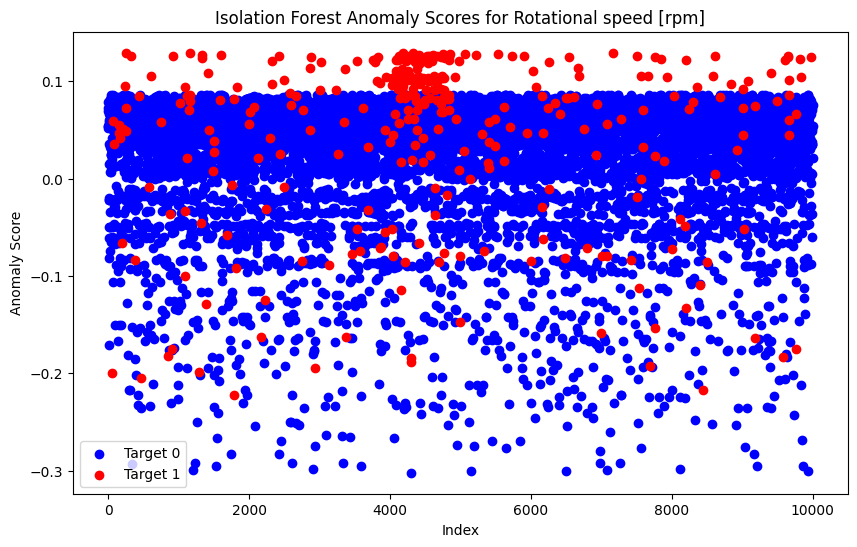

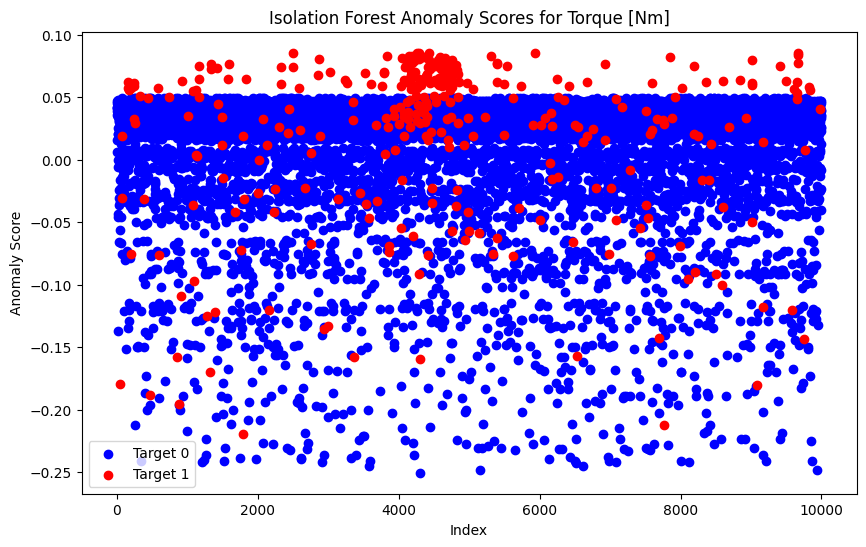

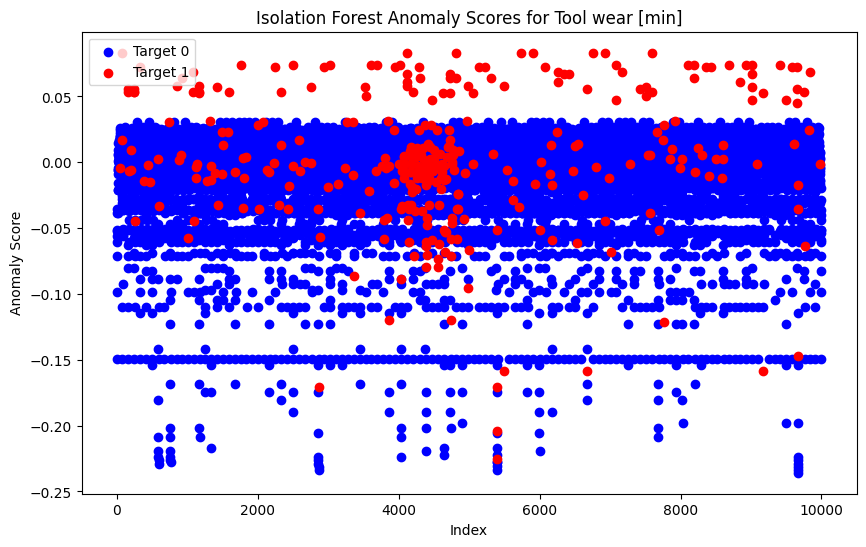

In [12]:
from sklearn.ensemble import IsolationForest

for sensor in df.columns:
  if sensor != 'Target' and pd.api.types.is_numeric_dtype(df[sensor]):
    # Separate data for target 0 and 1
    df_target_0 = df[df['Target'] == 0][[sensor]]
    df_target_1 = df[df['Target'] == 1][[sensor]]

    # Train Isolation Forest for target 0
    model_0 = IsolationForest(contamination='auto', random_state=42)
    model_0.fit(df_target_0)

    # Train Isolation Forest for target 1
    model_1 = IsolationForest(contamination='auto', random_state=42)
    model_1.fit(df_target_1)


    # Predict anomaly scores for target 0
    anomaly_scores_0 = model_0.decision_function(df_target_0)

    # Predict anomaly scores for target 1
    anomaly_scores_1 = model_1.decision_function(df_target_1)

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.scatter(df_target_0.index, anomaly_scores_0, color='blue', label='Target 0')
    plt.scatter(df_target_1.index, anomaly_scores_1, color='red', label='Target 1')
    plt.title(f'Isolation Forest Anomaly Scores for {sensor}')
    plt.xlabel('Index')
    plt.ylabel('Anomaly Score')
    plt.legend()
    plt.show()


Isolation Forest for Anomaly detection.
*   Red Cluster -> High failure Ideal stuff
*   High Blue Density == safe zonee
*   Isolated red islands == special failure or dif failure









Target
0    9661
1     339
Name: count, dtype: int64


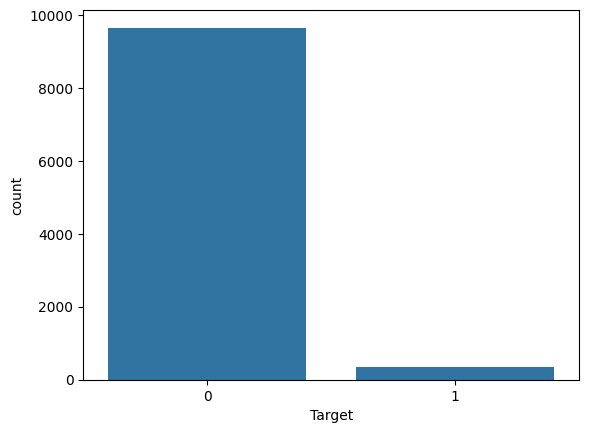

Probability of Failure True: 0.0339
Probability of Failure False: 0.9661


In [13]:
print(df['Target'].value_counts())
sns.countplot(x=df['Target'])
plt.show()

work = df[df['Target']==0]
fail = df[df['Target']==1]

num_work=work['Target'].shape[0]
num_fail=fail['Target'].shape[0]

print(f"Probability of Failure True: {num_fail/(num_work+num_fail)}")
print(f"Probability of Failure False: {num_work/(num_work+num_fail)}")

In [14]:
print(df.head())

   Air temperature [K]  Process temperature [K]  Rotational speed [rpm]  \
0                298.1                    308.6                    1551   
1                298.2                    308.7                    1408   
2                298.1                    308.5                    1498   
3                298.2                    308.6                    1433   
4                298.2                    308.7                    1408   

   Torque [Nm]  Tool wear [min]  Target  
0         42.8                0       0  
1         46.3                3       0  
2         49.4                5       0  
3         39.5                7       0  
4         40.0                9       0  


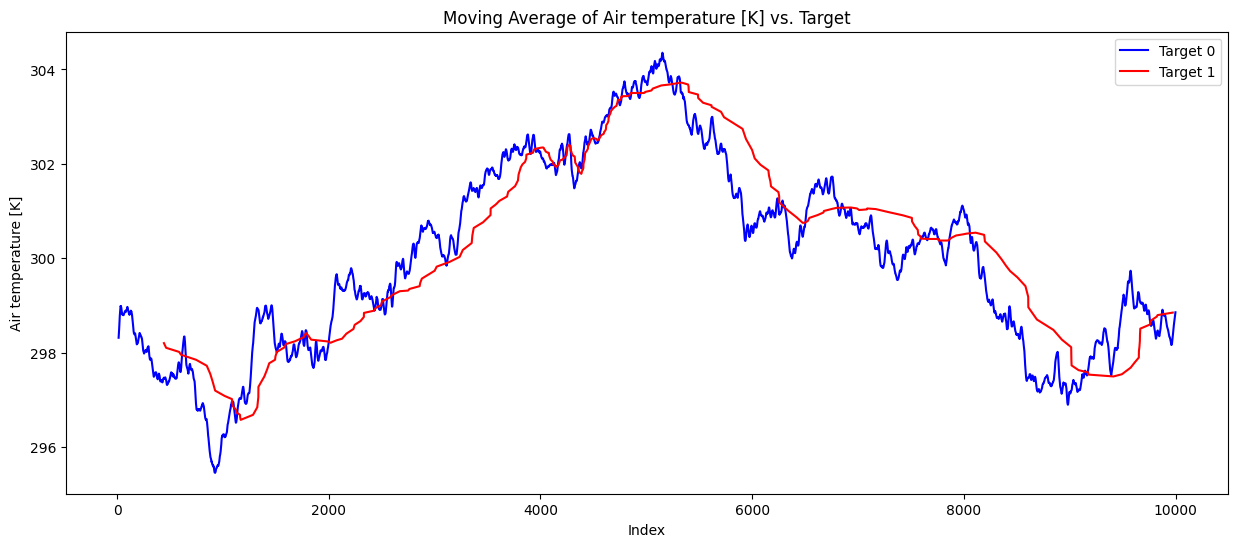

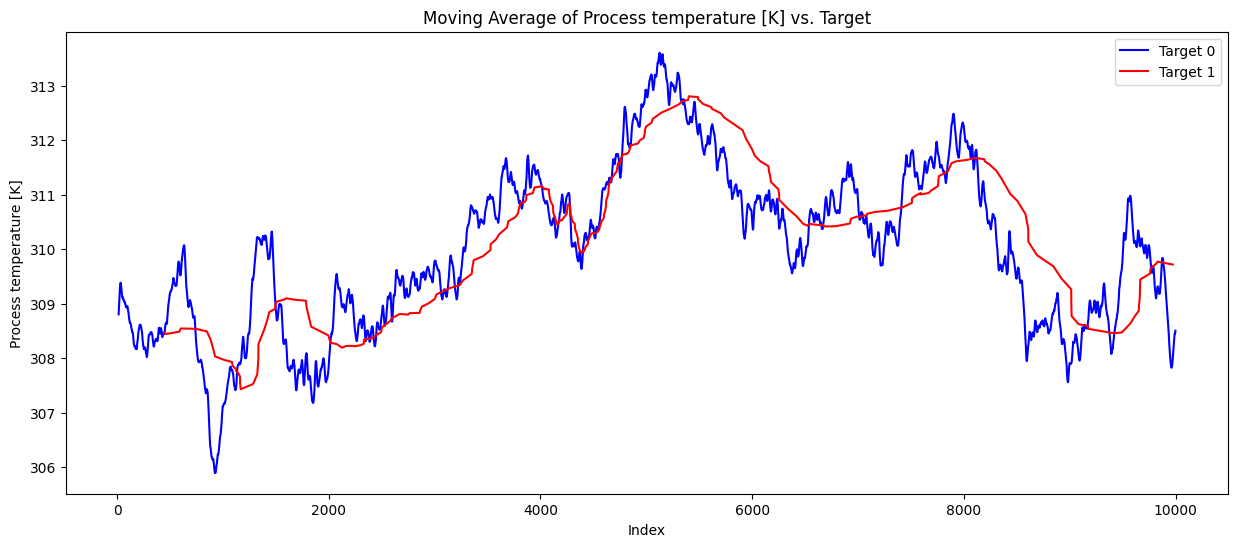

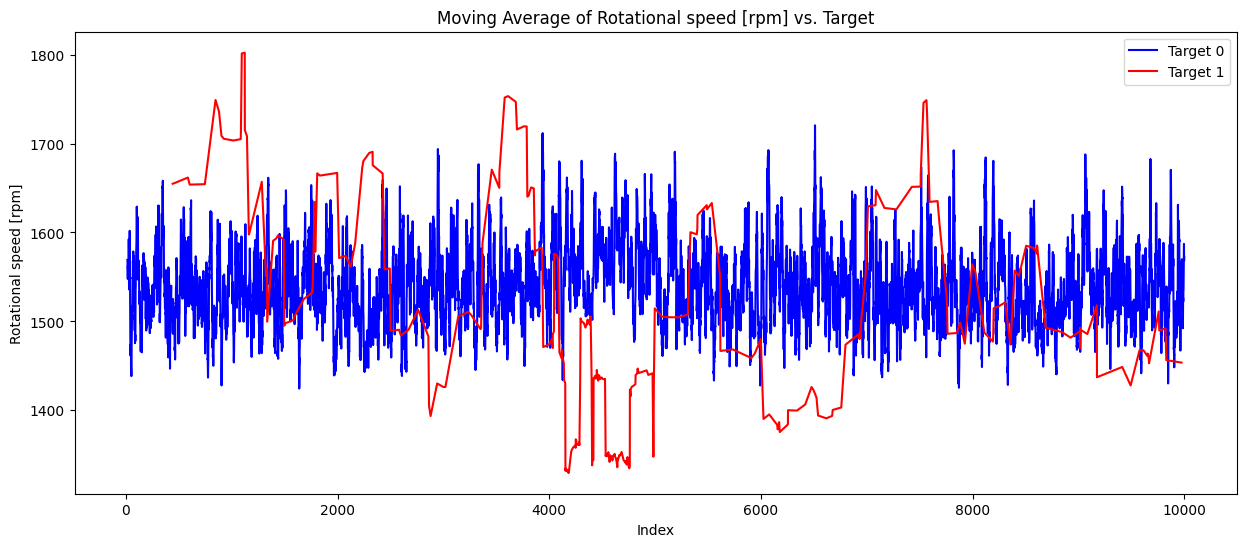

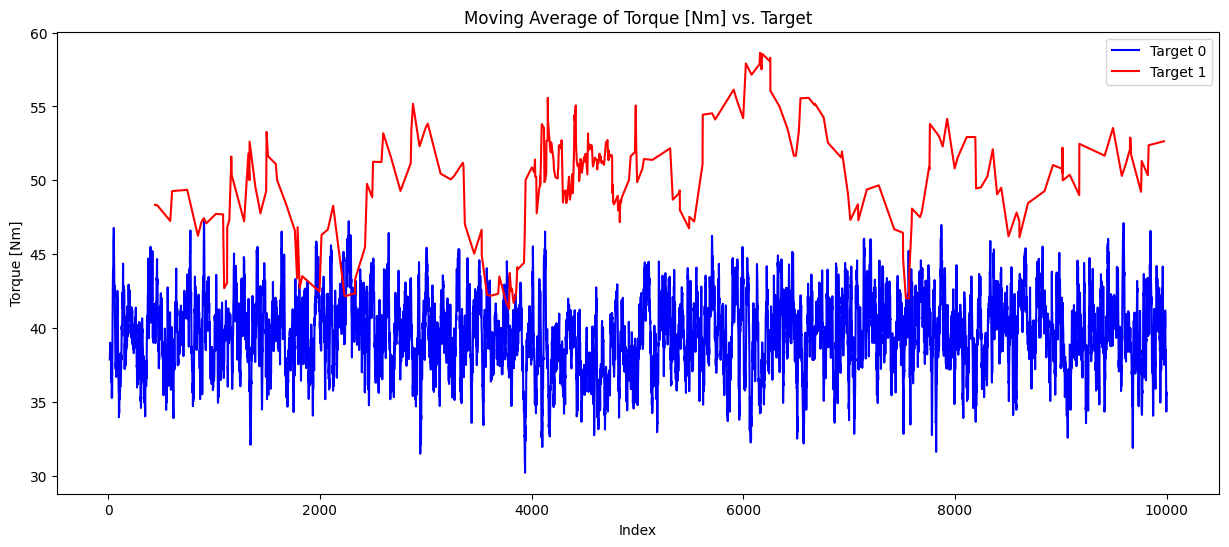

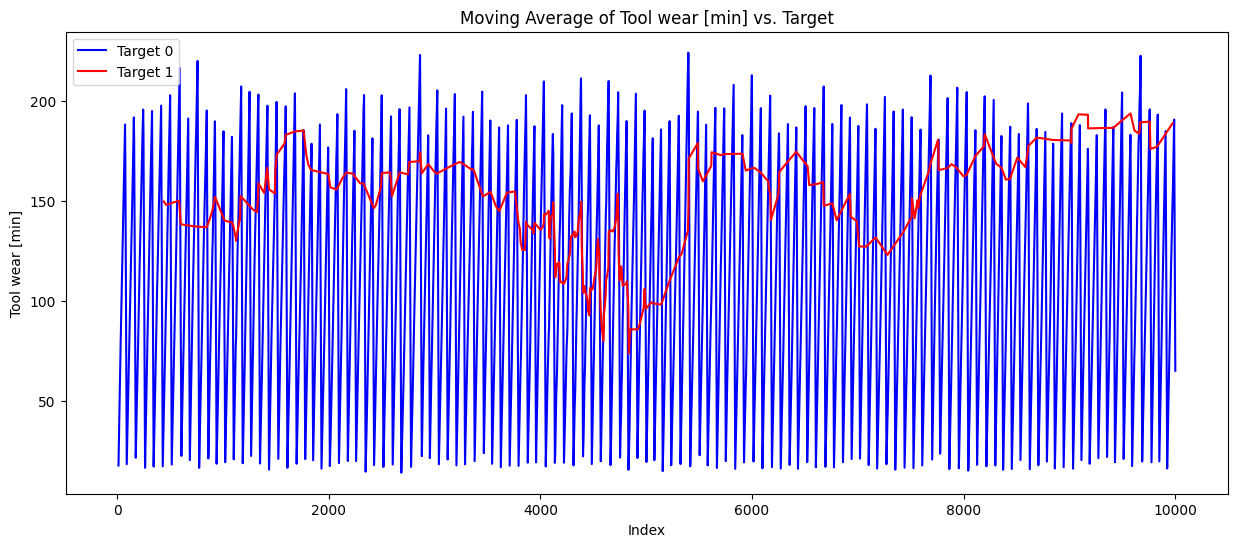

In [19]:
for sensor in df.columns:
  if sensor != 'Target' and pd.api.types.is_numeric_dtype(df[sensor]):
    plt.figure(figsize=(15, 6))

    # Calculate the rolling mean for target 0 and 1 separately
    df_target_0 = df[df['Target'] == 0]
    rolling_mean_0 = df_target_0[sensor].rolling(window=15).mean()

    df_target_1 = df[df['Target'] == 1]
    rolling_mean_1 = df_target_1[sensor].rolling(window=15).mean()

    # Plot the rolling mean for target 0 and 1
    plt.plot(rolling_mean_0, label='Target 0', color='blue')
    plt.plot(rolling_mean_1, label='Target 1', color='red')
    plt.title(f'Moving Average of {sensor} vs. Target')
    plt.xlabel('Index')
    plt.ylabel(sensor)
    plt.legend()
    plt.show()


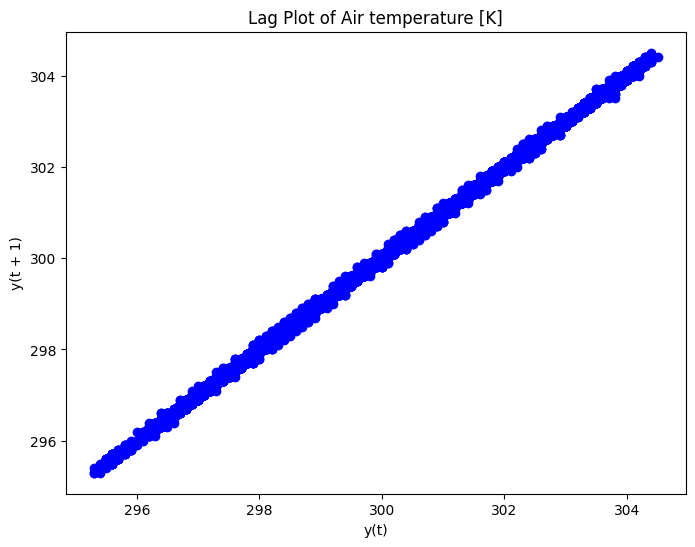

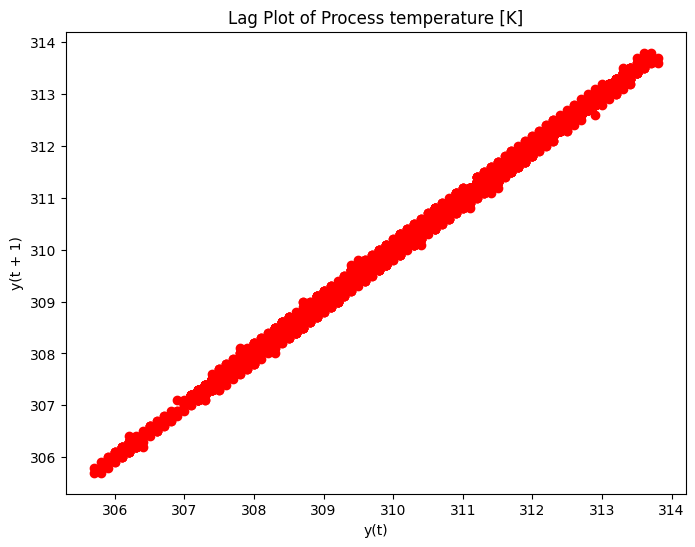

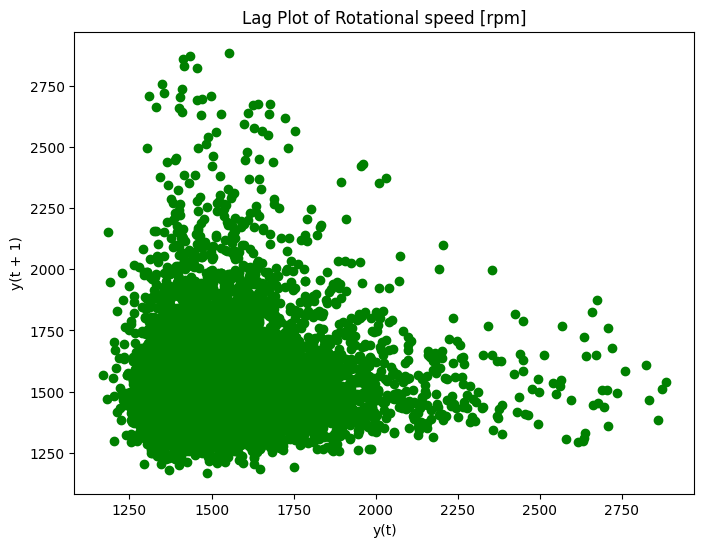

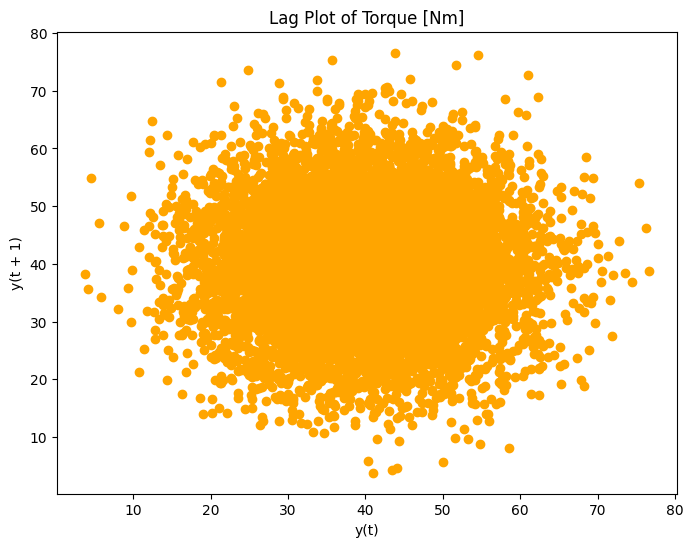

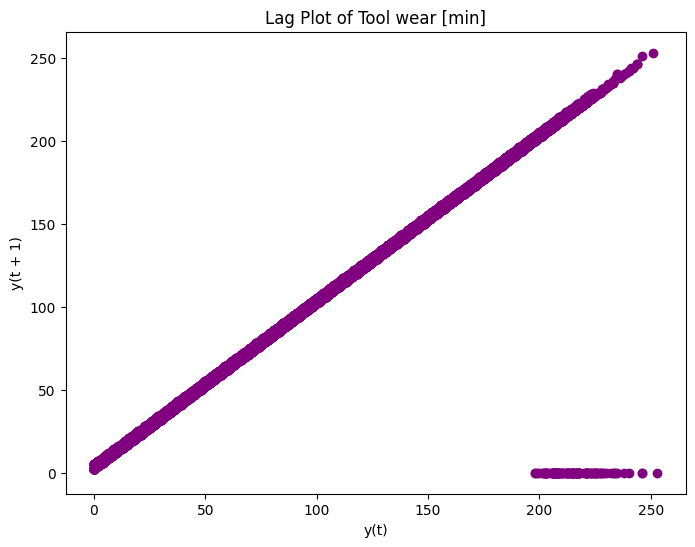

In [27]:
import itertools
from pandas.plotting import lag_plot
colors = itertools.cycle(['blue', 'red', 'green', 'orange', 'purple'])
for sensor in df.columns:
  if sensor != 'Target' and pd.api.types.is_numeric_dtype(df[sensor]):
    plt.figure(figsize=(8, 6))
    lag_plot(df[sensor], c=next(colors))
    plt.title(f'Lag Plot of {sensor}')
    plt.show()
